In [1]:
import time
from dataclasses import dataclass

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from IPython import display

tf.version.VERSION

'2.6.0'

In [2]:
@dataclass
class Config:
    DATASET = 'horse2zebra'
    # DATASET = 'apple2orange'
    
    INIT_LEARNING_RATE = 2e-4
    MIN_LEARNING_RATE = 1e-6
    
    BATCH_SIZE = 1
    EPOCHS = 100
    BUFFER_SIZE = 500
    LOAD_SIZE = 286
    INPUT_SIZE = 256
    
    INIT_STDDEV = 0.02
    
    LEAKY_RELU_ALPHA = 0.2
    BETA_1 = 0.5
    
    LAMBDA_A = 10.0
    LAMBDA_B = 10.0
    LAMBDA_IDENTITY = 0.5


config = Config()

In [3]:
data = tfds.load('cycle_gan/' + config.DATASET)
train_x = data['trainA']
train_y = data['trainB']
test_x = data['testA']
test_y = data['testB']

print('train_x: ', train_x)
print('train_y: ', train_y)
print('test_x: ', test_x)
print('test_y: ', test_y)

train_x:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
train_y:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_x:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>
test_y:  <PrefetchDataset shapes: {image: (None, None, 3), label: ()}, types: {image: tf.uint8, label: tf.int64}>


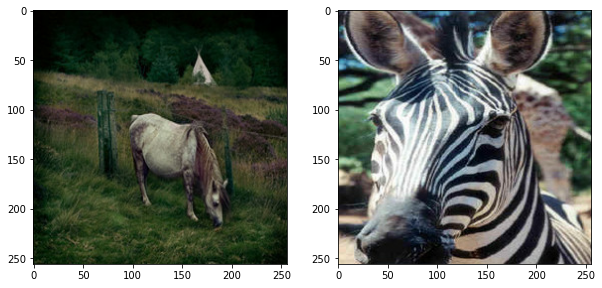

In [4]:
x = next(iter(test_x))
y = next(iter(test_y))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x['image'])

plt.subplot(1, 2, 2)
plt.imshow(y['image'])

plt.show()

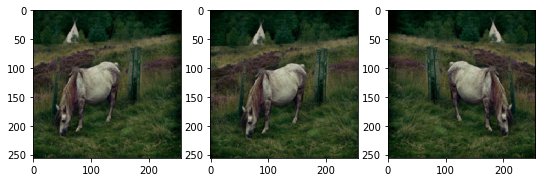

In [5]:
def normalize(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0


def random_jitter(image):
    image = tf.image.resize(
        image, [config.LOAD_SIZE, config.LOAD_SIZE],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.image.random_crop(image, [config.INPUT_SIZE, config.INPUT_SIZE, 3])
    image = tf.image.random_flip_left_right(image)
    return normalize(image)


plt.figure(figsize=(9, 3))
for i in range(3):
    distorted = random_jitter(x['image'])
    plt.subplot(1, 3, i+1)
    plt.imshow(distorted.numpy() * 0.5 + 0.5)
plt.show()

In [6]:
def train_pipeline(entry):
    return random_jitter(entry['image'])


def test_pipeline(entry):
    image = tf.image.resize(
        entry['image'], [config.INPUT_SIZE, config.INPUT_SIZE],
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return normalize(image)


train_x_ds = train_x.shuffle(config.BUFFER_SIZE).map(train_pipeline).batch(config.BATCH_SIZE, drop_remainder=True)
train_y_ds = train_y.shuffle(config.BUFFER_SIZE).map(train_pipeline).batch(config.BATCH_SIZE, drop_remainder=True)

test_x_ds = test_x.shuffle(config.BUFFER_SIZE).map(test_pipeline).batch(config.BATCH_SIZE, drop_remainder=True)
test_y_ds = test_y.shuffle(config.BUFFER_SIZE).map(test_pipeline).batch(config.BATCH_SIZE, drop_remainder=True)

print(train_x_ds)
print(train_y_ds)
print(test_x_ds)
print(test_y_ds)

<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>
<BatchDataset shapes: (1, 256, 256, 3), types: tf.float32>


In [7]:
kernel_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


def residual(x, activation, kernel_size=(3, 3), strides=(1, 1)):
    input_tensor = x
    d = x.shape[-1]
    x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], 'REFLECT')
    x = layers.Conv2D(
        d, kernel_size, strides=strides, padding='valid',
        kernel_initializer=kernel_initializer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)
    
    x = tf.pad(x, [[0, 0], [1, 1], [1, 1], [0, 0]], 'REFLECT')
    x = layers.Conv2D(
        d, kernel_size, strides=strides, padding='valid',
        kernel_initializer=kernel_initializer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    
    x = layers.add([input_tensor, x])
    return x


def downsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2)):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding='same',
        kernel_initializer=kernel_initializer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    
    if activation:
        x = activation(x)
    return x


def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same"):
    x = layers.Conv2DTranspose(
        filters, kernel_size, strides=strides, padding='same',
        kernel_initializer=kernel_initializer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    
    if activation:
        x = activation(x)
    return x


def build_generator(num_downsampling_blocks=2,
                    num_residual_blocks=9,
                    num_upsample_blocks=2):
    input_images = keras.layers.Input(shape=[config.INPUT_SIZE, config.INPUT_SIZE, 3])
    x = tf.pad(input_images, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    filters = 64
    x = keras.layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_initializer, use_bias=True)(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.ReLU()(x)
    
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.ReLU())
    
    for _ in range(num_residual_blocks):
        x = residual(x, activation=layers.ReLU())
    
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.ReLU())

    x = tf.pad(x, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)
    
    model = keras.models.Model(inputs=[input_images], outputs=[x])
    return model


def build_discriminator(num_downsampling=3):
    input_images = layers.Input(shape=[config.INPUT_SIZE, config.INPUT_SIZE, 3])
    filters = 64
    x = layers.Conv2D(
        filters, (4, 4), strides=(2, 2), padding='same',
        kernel_initializer=kernel_initializer)(input_images)
    x = layers.LeakyReLU(config.LEAKY_RELU_ALPHA)(x)

    num_filters = filters
    for num_downsample_block in range(num_downsampling):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x, filters=num_filters,
                activation=layers.LeakyReLU(config.LEAKY_RELU_ALPHA),
                kernel_size=(4, 4), strides=(2, 2))
        else:
            x = downsample(
                x, filters=num_filters,
                activation=layers.LeakyReLU(config.LEAKY_RELU_ALPHA),
                kernel_size=(4, 4),
                strides=(1, 1))

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=[input_images], outputs=[x])
    return model



keras.backend.clear_session()
A = build_generator()
B = build_generator()
A.summary()
B.summary()


DA = build_discriminator()
DB = build_discriminator()
DA.summary()
DB.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
tf.compat.v1.pad (TFOpLambda)   (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9472        tf.compat.v1.pad[0][0]           
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
______________________________________________________________________________________________

In [8]:
STEPS_PER_EPOCH = len(train_x_ds)
DECAY_STEPS = config.EPOCHS * STEPS_PER_EPOCH


def get_scheduler():
    return keras.optimizers.schedules.CosineDecay(
        config.INIT_LEARNING_RATE,
        DECAY_STEPS,
        alpha=config.MIN_LEARNING_RATE)


# optimizers
g_optimizer = keras.optimizers.Adam(get_scheduler(), beta_1=config.BETA_1)
d_optimizer = keras.optimizers.Adam(get_scheduler(), beta_1=config.BETA_1)

In [9]:
def identity_loss(y, cycled_y):
    return keras.losses.MeanAbsoluteError()(y, cycled_y)


def generator_loss(fake):
    return keras.losses.MeanSquaredError()(tf.ones_like(fake), fake)


def cycle_loss(y_true, y_pred):
    return keras.losses.MeanAbsoluteError()(y_true, y_pred)


def discriminator_loss(fake, real):
    loss_fn = keras.losses.MeanSquaredError()
    loss = loss_fn(tf.zeros_like(fake), fake) + loss_fn(tf.ones_like(real), real)
    return loss * 0.5


@tf.function(jit_compile=True)
def train_step(x, y, g_optimizer, d_optimizer):
    """
    G: x -> y
    F: y -> x
    Dg: y -> 1, y_hat -> 0
    Df: x -> 1, x_hat -> 0
    """
    
    with tf.GradientTape(persistent=True) as tape:
        y_hat = A(x, training=True)
        x_hat = B(y, training=True)
        same_y = A(y, training=True)
        same_x = B(x, training=True)
        fake_A = DA(y_hat, training=False)
        fake_B = DB(x_hat, training=False)
        cycle_x = B(y_hat, training=True)
        cycle_y = A(x_hat, training=True)
        
        loss_identity_A = identity_loss(y, same_y) * config.LAMBDA_A * config.LAMBDA_IDENTITY
        loss_identity_B = identity_loss(x, same_x) * config.LAMBDA_B * config.LAMBDA_IDENTITY
        loss_GA = generator_loss(fake_A)
        loss_GB = generator_loss(fake_B)
        loss_cycle_A = cycle_loss(y, cycle_y) * config.LAMBDA_A
        loss_cycle_B = cycle_loss(x, cycle_x) * config.LAMBDA_B
        
        loss_g = loss_GA + loss_GB + loss_cycle_A + loss_cycle_B + loss_identity_A + loss_identity_B
    
    g_vars = A.trainable_variables + B.trainable_variables
    g_grad = tape.gradient(loss_g, g_vars)
    g_optimizer.apply_gradients(zip(g_grad, g_vars))
    
    with tf.GradientTape(persistent=True) as tape:
        y_hat = A(x, training=False)
        x_hat = B(y, training=False)
        y_fake = DA(y_hat, training=True)
        x_fake = DB(x_hat, training=True)
        y_real = DA(y, training=True)
        x_real = DB(x, training=True)
        
        loss_DA = discriminator_loss(y_fake, y_real)
        loss_DB = discriminator_loss(x_fake, x_real)
    
    da_grad = tape.gradient(loss_DA, DA.trainable_variables)
    d_optimizer.apply_gradients(zip(da_grad, DA.trainable_variables))
    
    d_optimizer.iterations.assign_add(-1)
    
    db_grad = tape.gradient(loss_DB, DB.trainable_variables)
    d_optimizer.apply_gradients(zip(db_grad, DB.trainable_variables))
    
    return loss_g, loss_DA, loss_DB, g_optimizer.iterations, d_optimizer.iterations


train_ds = tf.data.Dataset.zip((train_x_ds, train_y_ds))
train_iter = iter(train_ds)
x, y = next(train_iter)
train_step(x, y, g_optimizer, d_optimizer)

(<tf.Tensor: shape=(), dtype=float32, numpy=10.214791>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.50081366>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.500182>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [10]:
%timeit train_step(x, y, g_optimizer, d_optimizer)

271 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


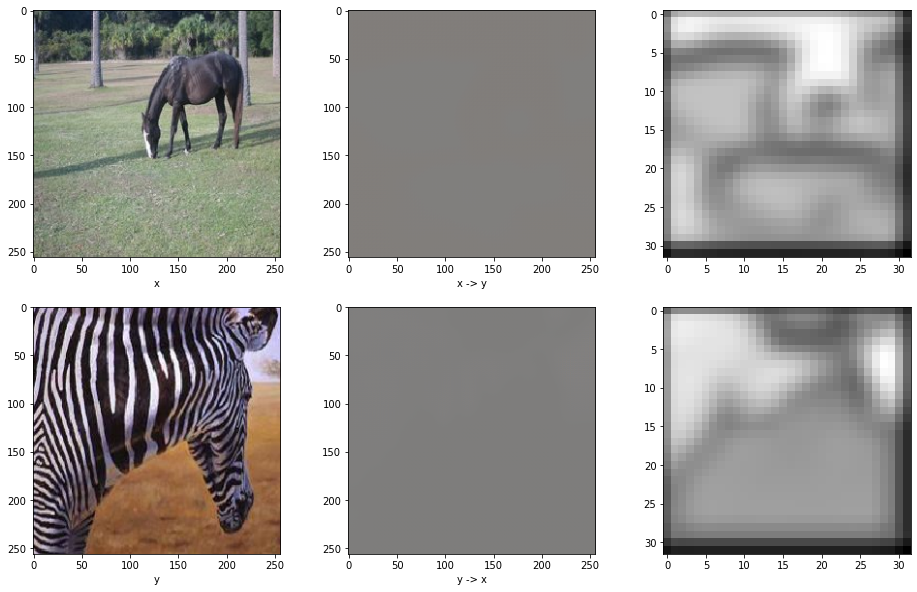

In [11]:
def generate_images(x, y):
    fake_y = A(x, training=False)
    fake_x = B(y, training=False)
    da_map = DA(fake_x, training=False)
    db_map = DB(fake_y, training=False)
    
    plt.subplot(2, 3, 1)
    plt.imshow(x[0].numpy() * 0.5 + 0.5)
    plt.xlabel('x')
    
    plt.subplot(2, 3, 2)
    plt.imshow(fake_y[0].numpy() * 0.5 + 0.5)
    plt.xlabel('x -> y')
    
    plt.subplot(2, 3, 3)
    plt.imshow(db_map[0, :, :, 0].numpy(), cmap='gray')
    
    plt.subplot(2, 3, 4)
    plt.imshow(y[0].numpy() * 0.5 + 0.5)
    plt.xlabel('y')
    
    plt.subplot(2, 3, 5)
    plt.imshow(fake_x[0].numpy() * 0.5 + 0.5)
    plt.xlabel('y -> x')
    
    plt.subplot(2, 3, 6)
    plt.imshow(da_map[0, :, :, 0].numpy(), cmap='gray')


plt.figure(figsize=(16, 10))
x, y = next(train_iter)
generate_images(x, y)
plt.show()

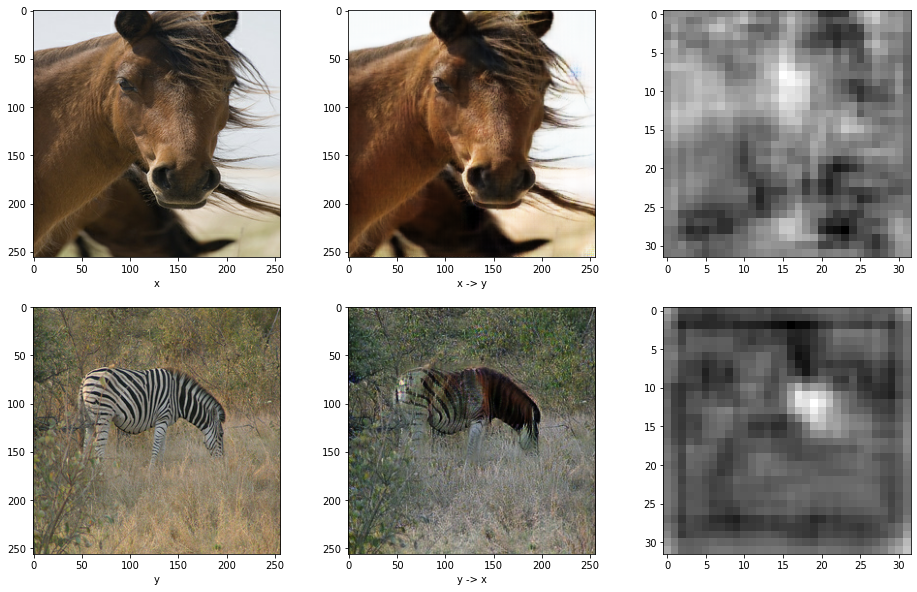

time used last epoch:  301.40024518966675
epoch:  99
1066. loss_g: 3.2081494331359863, loss_DA: 0.07901275157928467, loss_DB: 0.14317245781421664

In [12]:
def train(train_ds, test_ds):
    test_repeat = test_ds.repeat()
    test_iter = iter(test_repeat)
    time_used = 0
    for epoch in range(config.EPOCHS):
        display.clear_output(wait=True)
        
        test_x, test_y = next(test_iter)
        plt.figure(figsize=(16, 10))
        generate_images(test_x, test_y)
        plt.show()
        
        if time_used:
            print('time used last epoch: ', time_used)
        
        print('epoch: ', epoch)
        start = time.time()
        losses = [[] for _ in range(3)]
        step = 0
        for x, y in train_ds:
            l = train_step(x, y, g_optimizer, d_optimizer)
            for i in range(3):
                losses[i].append(l[i].numpy())
            print(f'\r{step}. loss_g: {np.mean(losses[0])}, loss_DA: {np.mean(losses[1])}, loss_DB: {np.mean(losses[2])}', end='')
            step += 1
        time_used = time.time() - start


test_ds = tf.data.Dataset.zip((test_x_ds, test_y_ds))
train(train_ds, test_ds)

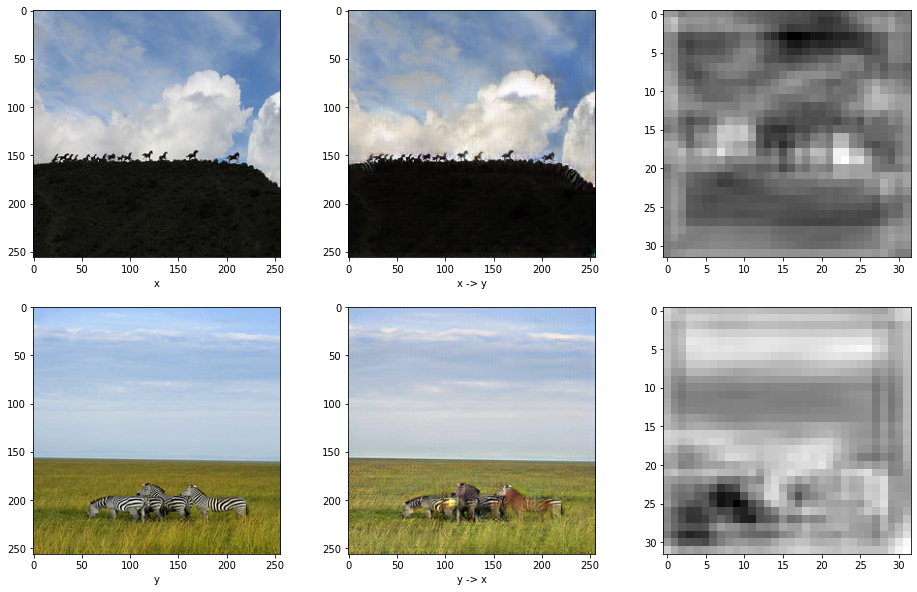

In [13]:
test_repeat_ds = test_ds.repeat()
test_iter = iter(test_repeat_ds)

def show_image():
    plt.figure(figsize=(16, 10))
    horses, zebras = next(test_iter)
    generate_images(horses, zebras)
    plt.show()


show_image()

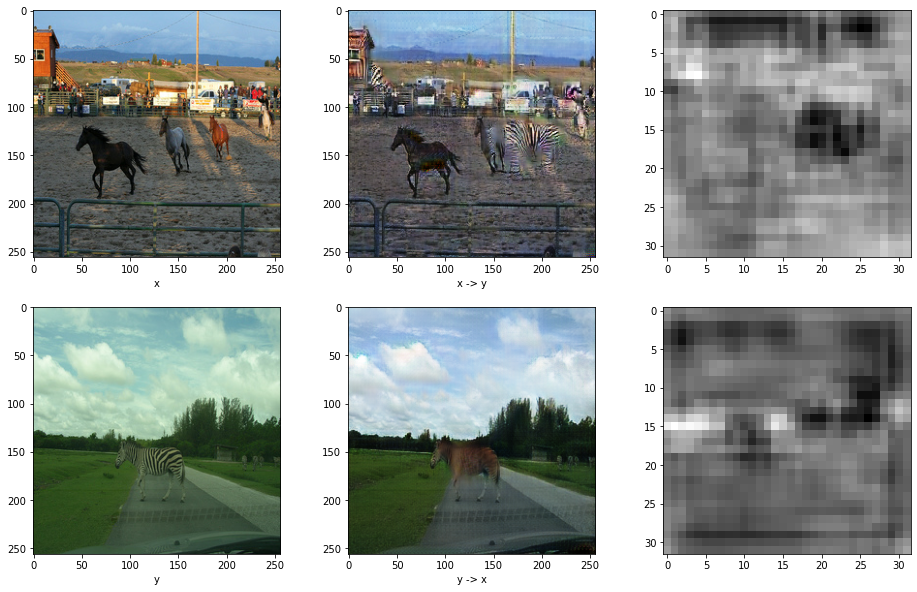

In [14]:
show_image()

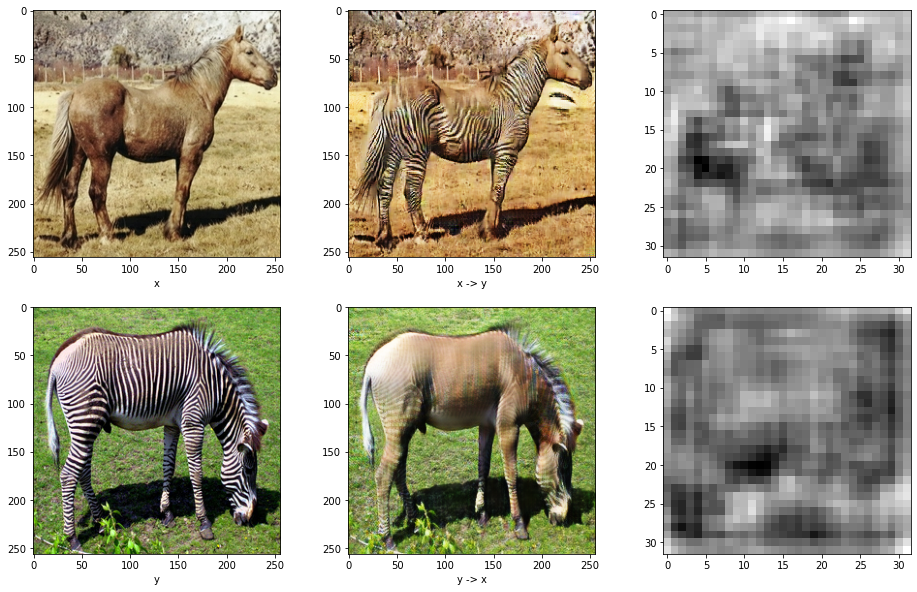

In [15]:
show_image()

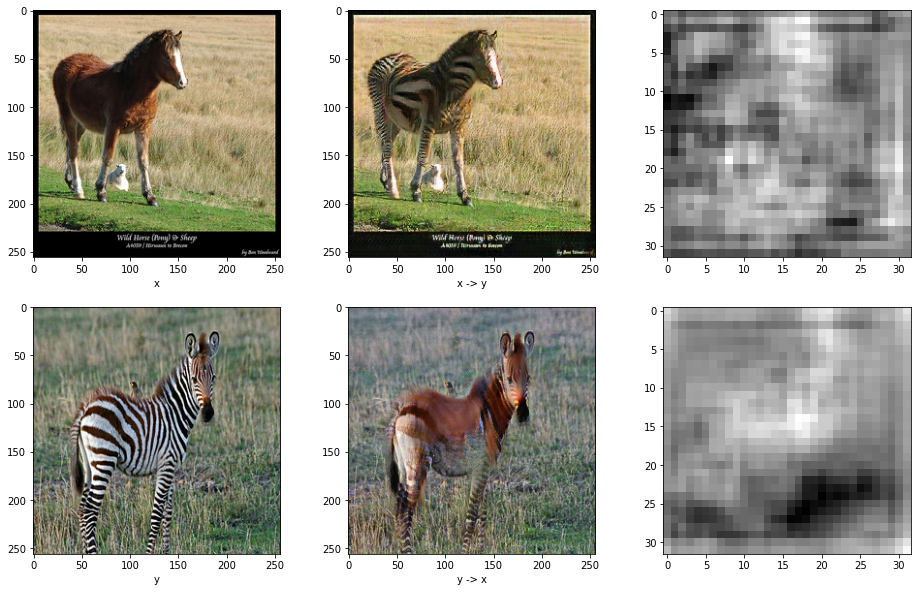

In [16]:
show_image()

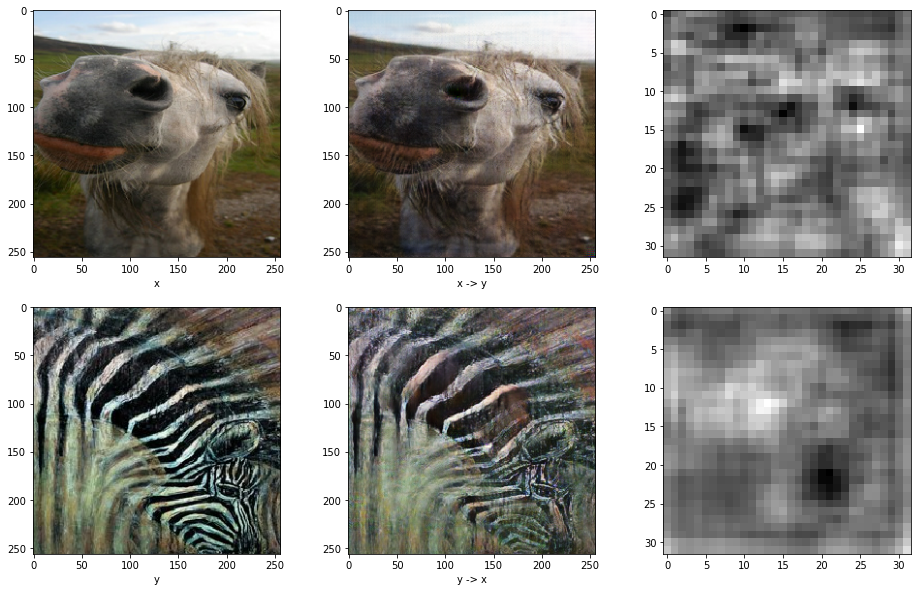

In [17]:
train_repeat_ds = train_ds.repeat()
train_repeat_iter = iter(train_repeat_ds)

def show_train_image():
    plt.figure(figsize=(16, 10))
    horses, zebras = next(train_repeat_iter)
    generate_images(horses, zebras)
    plt.show()


show_train_image()

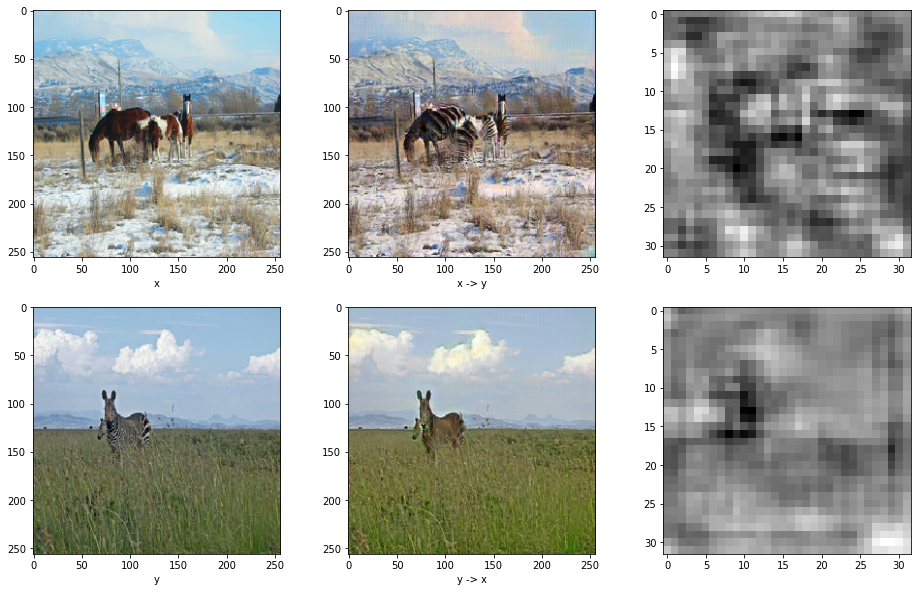

In [18]:
show_train_image()

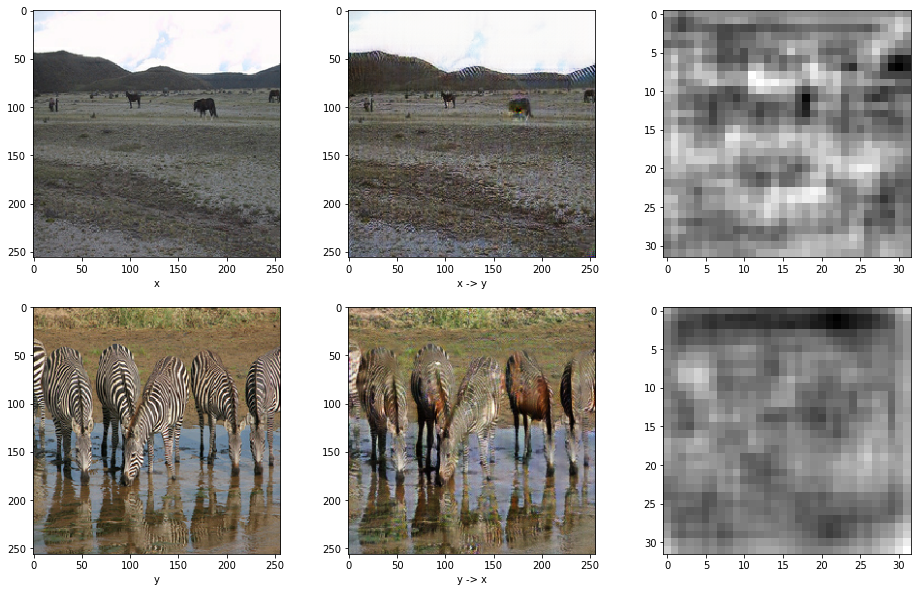

In [19]:
show_train_image()

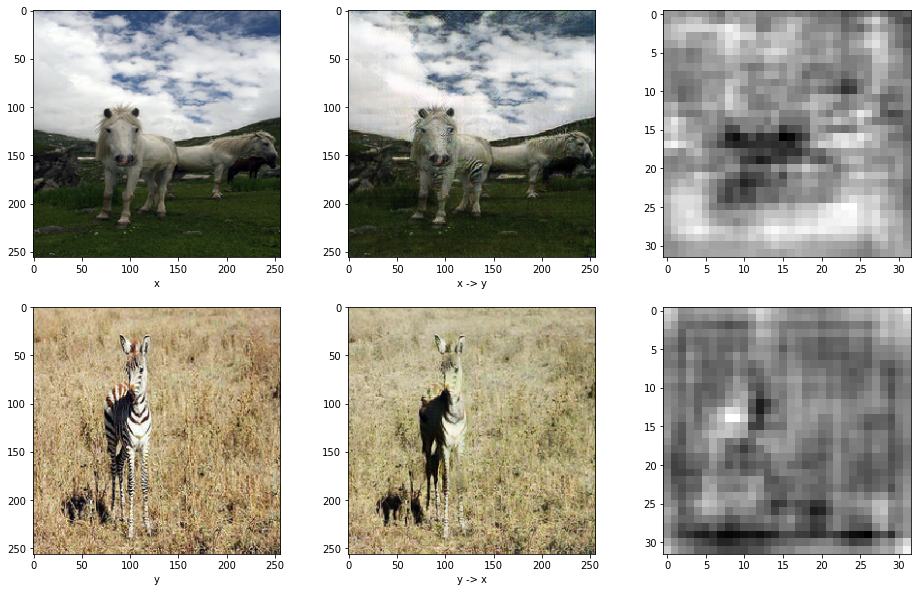

In [20]:
show_train_image()

In [22]:
model_path = f'saved_models/cycle_gan/{config.DATASET}'

A.save(f'{model_path}/A')
B.save(f'{model_path}/B')
DA.save(f'{model_path}/DA')
DB.save(f'{model_path}/DB')

INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/A/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/A/assets
/home/kiddos/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/B/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/B/assets
/home/kiddos/.local/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/DA/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/DA/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/DB/assets


INFO:tensorflow:Assets written to: saved_models/cycle_gan/horse2zebra/DB/assets


In [23]:
checkpoint = tf.train.Checkpoint()
checkpoint.save('checkpoint/%s/%s.1.checkpoint' % (config.DATASET, config.DATASET))

'checkpoint/horse2zebra/horse2zebra.1.checkpoint-1'